# Implied volatility

## methodology

In [2]:
from IPython.display import display, Math, Latex
print('BSM call price')
display(Math(r'C(t, T, S_t, K, r, \sigma) = S_t N(d_1) - e^{-r (T-t)} K N(d_2)'))
display(Math(r'N(d)=.., d_1=.., d_2=..'))

BSM call price


<IPython.core.display.Math object>

<IPython.core.display.Math object>

implied volatility is such that solves

In [3]:
display(Math(r'C(t, T, S_t, K, r, \sigma^{imp}) = C^*'))

<IPython.core.display.Math object>

The above does not have closed-form solution. So some numerical procedure has to be used. E.g. Newton scheme, for certain number of iterations/certain degree of precision, and starting value of sigma imp.

In [4]:
display(Math(r'\sigma^{imp} = \sigma^*'))
display(Math(r'\sigma_{n+1}^* = \sigma_n^* - \frac{C(\sigma_n^*) - C^*}{\frac{\partial C(\sigma_n^*)}{\partial \sigma_n^*}}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

partial derivative above is actually an option vega, which has a closed-form solution under bsm

In [5]:
display(Math(r'\nu = \frac{\partial C}{\partial \sigma} = S_t N(d_1) \sqrt{T-t}'))

<IPython.core.display.Math object>

python implementation of those are in `bsm_functions.py`
- bsm_call_value()
- bsm_vega()
- bsm_call_imp_vol()

NB: the above are for t=0

## deriving

In [6]:
from pylab import plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')

HDFS file `vstoxx_data_31032014.h5` contains mkt data on VSTOXX futures and call options on VSTOXX futures


In [7]:
import pandas as pd
vstoxx_h5 = pd.HDFStore('./resources/vstoxx_data_31032014.h5', 'r')
print(vstoxx_h5.keys())
futures = vstoxx_h5['futures_data']
calls = vstoxx_h5['options_data']
vstoxx_h5.close()

['/futures_data', '/options_data']


In [8]:
futures

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,1396224000000000000,2014,4,17.85,1397779200000000000,0.049
497,1396224000000000000,2014,5,19.55,1400198400000000000,0.126
498,1396224000000000000,2014,6,19.95,1403222400000000000,0.222
499,1396224000000000000,2014,7,20.40,1405641600000000000,0.299
500,1396224000000000000,2014,8,20.70,1408060800000000000,0.375
501,1396224000000000000,2014,9,20.95,1411084800000000000,0.471
502,1396224000000000000,2014,10,21.05,1413504000000000000,0.548
503,1396224000000000000,2014,11,21.25,1416528000000000000,0.644


That's the data as of Mar 31, 2014. There are total 8 futures trading. TTM is time-to-maturity in year fraction

Spot on that date was 17.6639 which becomes our V0 (a.k.a S(t0)). Risk-free assume 1%

In [9]:
V0 = 17.6639

In [10]:
r = 0.01

Lets also transform datetime format

In [11]:
import datetime as dt

In [12]:
futures['DATE'] = futures['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [13]:
futures['MATURITY'] = futures['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [14]:
futures

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31 02:00:00,2014,4,17.85,2014-04-18 02:00:00,0.049
497,2014-03-31 02:00:00,2014,5,19.55,2014-05-16 02:00:00,0.126
498,2014-03-31 02:00:00,2014,6,19.95,2014-06-20 02:00:00,0.222
499,2014-03-31 02:00:00,2014,7,20.40,2014-07-18 02:00:00,0.299
500,2014-03-31 02:00:00,2014,8,20.70,2014-08-15 02:00:00,0.375
501,2014-03-31 02:00:00,2014,9,20.95,2014-09-19 02:00:00,0.471
502,2014-03-31 02:00:00,2014,10,21.05,2014-10-17 02:00:00,0.548
503,2014-03-31 02:00:00,2014,11,21.25,2014-11-21 01:00:00,0.644


Now lets look at calls. There are many options available with multiple strikes, total of 395 calls out there. The maturuties match futures' maturities though: thats a 3rd Friday of every month.

In [15]:
calls.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,1396224000000000000,2014,4,C,1.0,16.85,1397779200000000000,0.049
46171,1396224000000000000,2014,4,C,2.0,15.85,1397779200000000000,0.049
46172,1396224000000000000,2014,4,C,3.0,14.85,1397779200000000000,0.049
46173,1396224000000000000,2014,4,C,4.0,13.85,1397779200000000000,0.049
46174,1396224000000000000,2014,4,C,5.0,12.85,1397779200000000000,0.049


Same datetime format transformation

In [16]:
calls['DATE'] = calls['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [17]:
calls['MATURITY'] = calls['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [18]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [19]:
calls

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,2014-03-31 02:00:00,2014,4,C,1.0,16.85,2014-04-18 02:00:00,0.049
46171,2014-03-31 02:00:00,2014,4,C,2.0,15.85,2014-04-18 02:00:00,0.049
46172,2014-03-31 02:00:00,2014,4,C,3.0,14.85,2014-04-18 02:00:00,0.049
46173,2014-03-31 02:00:00,2014,4,C,4.0,13.85,2014-04-18 02:00:00,0.049
46174,2014-03-31 02:00:00,2014,4,C,5.0,12.85,2014-04-18 02:00:00,0.049
46175,2014-03-31 02:00:00,2014,4,C,6.0,11.85,2014-04-18 02:00:00,0.049
46176,2014-03-31 02:00:00,2014,4,C,7.0,10.85,2014-04-18 02:00:00,0.049
46177,2014-03-31 02:00:00,2014,4,C,8.0,9.85,2014-04-18 02:00:00,0.049
46178,2014-03-31 02:00:00,2014,4,C,9.0,8.85,2014-04-18 02:00:00,0.049
46179,2014-03-31 02:00:00,2014,4,C,10.0,7.85,2014-04-18 02:00:00,0.049


In [20]:
calls[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31 02:00:00,2014-04-18 02:00:00,0.049,1.0,16.85
46171,2014-03-31 02:00:00,2014-04-18 02:00:00,0.049,2.0,15.85
46172,2014-03-31 02:00:00,2014-04-18 02:00:00,0.049,3.0,14.85
46173,2014-03-31 02:00:00,2014-04-18 02:00:00,0.049,4.0,13.85
46174,2014-03-31 02:00:00,2014-04-18 02:00:00,0.049,5.0,12.85


In [21]:
from bsm_functions import *

Now getting to calculations

As we have some deep otms and deep itms, we would want to limit the moneyness (forward moneyness)

We will use 50% moneyness as our main parameter. We will also use 400% moneyness to show the right side of volatility smile.

adding new columns for implied volatility and moneyness var

In [22]:
calls['IMP_VOL'] = 0.0
calls['IMP_VOL_400'] = 0.0
moneyness_tolerance = 0.5
moneyness_top = 1 + moneyness_tolerance
moneyness_bottom = 1 - moneyness_tolerance

In [23]:
for each in calls.index:
    
    fwd_price = futures[futures['MATURITY'] == calls.loc[each]['MATURITY']]['PRICE'].values[0]    
    
    if (fwd_price * moneyness_bottom < calls.loc[each]['STRIKE'] < fwd_price * moneyness_top):
        
        implied = bsm_call_imp_vol(S0=V0,
                                   K=calls.loc[each]['STRIKE'],
                                   T=calls.loc[each]['TTM'],
                                   r=r,
                                   C0=calls.loc[each]['PRICE'],
                                   sigma_est=2.,  # estimate for implied volatility
                                   it=100) #iterations
        calls.ix[each, 'IMP_VOL'] = implied

repeat for 400% moneyness

In [24]:
moneyness_tolerance = 4
moneyness_top = 1 + moneyness_tolerance
moneyness_bottom = 1 - moneyness_tolerance

In [25]:
for each in calls.index:
    
    fwd_price = futures[futures['MATURITY'] == calls.loc[each]['MATURITY']]['PRICE'].values[0]    
    
    if (fwd_price * moneyness_bottom < calls.loc[each]['STRIKE'] < fwd_price * moneyness_top):
        
        implied = bsm_call_imp_vol(S0=V0,
                                   K=calls.loc[each]['STRIKE'],
                                   T=calls.loc[each]['TTM'],
                                   r=r,
                                   C0=calls.loc[each]['PRICE'],
                                   sigma_est=2.,  # estimate for implied volatility
                                   it=100) #iterations
        calls.ix[each, 'IMP_VOL_400'] = implied

In [26]:
calls

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMP_VOL,IMP_VOL_400
46170,2014-03-31 02:00:00,2014,4,C,1.0,16.85,2014-04-18 02:00:00,0.049,0.000000,NaN
46171,2014-03-31 02:00:00,2014,4,C,2.0,15.85,2014-04-18 02:00:00,0.049,0.000000,NaN
46172,2014-03-31 02:00:00,2014,4,C,3.0,14.85,2014-04-18 02:00:00,0.049,0.000000,NaN
46173,2014-03-31 02:00:00,2014,4,C,4.0,13.85,2014-04-18 02:00:00,0.049,0.000000,NaN
46174,2014-03-31 02:00:00,2014,4,C,5.0,12.85,2014-04-18 02:00:00,0.049,0.000000,NaN
46175,2014-03-31 02:00:00,2014,4,C,6.0,11.85,2014-04-18 02:00:00,0.049,0.000000,3.163465
46176,2014-03-31 02:00:00,2014,4,C,7.0,10.85,2014-04-18 02:00:00,0.049,0.000000,2.750128
46177,2014-03-31 02:00:00,2014,4,C,8.0,9.85,2014-04-18 02:00:00,0.049,0.000000,2.395246
46178,2014-03-31 02:00:00,2014,4,C,9.0,8.85,2014-04-18 02:00:00,0.049,2.083388,2.083388
46179,2014-03-31 02:00:00,2014,4,C,10.0,7.85,2014-04-18 02:00:00,0.049,1.804193,1.804193


so implied numbers for 50 and 400 % tolerance match, its just that the latter has more values on the tails.

now lets plot the thing

we will plot only non-zero values

In [27]:
plot_50 = calls[calls['IMP_VOL'] > 0]
plot_400 = calls[calls['IMP_VOL_400'] > 0]

In [28]:
futures['MATURITY']

496   2014-04-18 02:00:00
497   2014-05-16 02:00:00
498   2014-06-20 02:00:00
499   2014-07-18 02:00:00
500   2014-08-15 02:00:00
501   2014-09-19 02:00:00
502   2014-10-17 02:00:00
503   2014-11-21 01:00:00
Name: MATURITY, dtype: datetime64[ns]

The same won't work for calls as there multiple options for same maturity. So `set()` creates unique, `sorted()` well sorts them

In [29]:
maturities = sorted(set(calls['MATURITY']))
maturities

[Timestamp('2014-04-18 02:00:00'),
 Timestamp('2014-05-16 02:00:00'),
 Timestamp('2014-06-20 02:00:00'),
 Timestamp('2014-07-18 02:00:00'),
 Timestamp('2014-08-15 02:00:00'),
 Timestamp('2014-09-19 02:00:00'),
 Timestamp('2014-10-17 02:00:00'),
 Timestamp('2014-11-21 01:00:00')]

To visualize the data, we iterate over all maturities of the data set and plot the implied
volatilities both as lines and as single points.

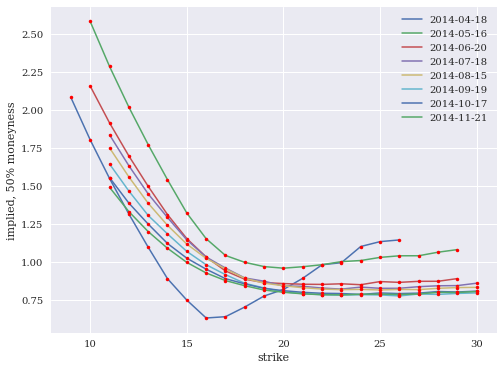

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8, 6))

for each in maturities:
    
    data_for_maturity = plot_50[calls.MATURITY == each]
      
    
    # line
    plt.plot(data_for_maturity['STRIKE'], 
             data_for_maturity['IMP_VOL'],
             label=each.date(), 
             lw=1.5)
    
    # dots
    plt.plot(data_for_maturity['STRIKE'], 
             data_for_maturity['IMP_VOL'], 
             'r.', 
             label='')

plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied, 50% moneyness')
plt.legend()
plt.show()

Same for 400% moneyness

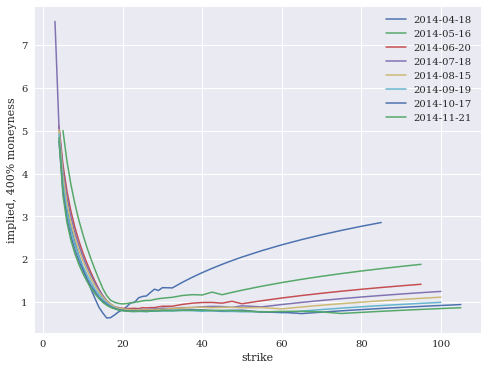

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8, 6))

for each in maturities:
    
    data_for_maturity = plot_400[calls.MATURITY == each]
      
    
    # line
    plt.plot(data_for_maturity['STRIKE'], 
             data_for_maturity['IMP_VOL_400'],
             label=each.date(), 
             lw=1.5)

plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied, 400% moneyness')
plt.legend()
plt.show()

## some pandas stuff

select data row for index 46170

In [32]:
calls.loc[46170]

DATE           2014-03-31 02:00:00
EXP_YEAR                      2014
EXP_MONTH                        4
TYPE                             C
STRIKE                           1
PRICE                        16.85
MATURITY       2014-04-18 02:00:00
TTM                          0.049
IMP_VOL                          0
IMP_VOL_400                    NaN
Name: 46170, dtype: object

select only the value in column STRIKE, for index 46170 

In [33]:
calls.loc[46170]['STRIKE']

1.0

The `DataFrame` object `calls` has an integer index, which we have used in several places. However, this index is not really
meaningful—it is “just” a number. The option quotes for the day March 31, 2014 are uniquely described (“identified”) by a combination of the maturity and the strike—i.e., there is only one call option per maturity and strike.

The `groupby` method can be used to capitalize on this insight and to get a more meaningful index. To this end, we group by `MATURITY` first and then by the `STRIKE`. We only want to keep the `PRICE` and `IMP_VOL` columns

In [34]:
keep = ['PRICE', 'IMP_VOL']
grouped = plot_50.groupby(['MATURITY', 'STRIKE'])[keep]
grouped

The operation returns a `DataFrameGroupBy` object. To get to the data, we need to apply an aggregation operation on the object, like taking the `sum`. Taking the `sum` yields the single data point since there is only one data element in every group:

In [35]:
grouped = grouped.sum()
grouped

PRICE   IMP_VOL
MATURITY            STRIKE                 
2014-04-18 02:00:00 9.0      8.85  2.083388
                    10.0     7.85  1.804193
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184
                    14.0     3.85  0.889581
                    15.0     2.90  0.748630
                    16.0     2.00  0.630958
                    17.0     1.35  0.639297
                    18.0     0.95  0.703208
                    19.0     0.70  0.775629
                    20.0     0.50  0.818813
                    21.0     0.40  0.892494
                    22.0     0.35  0.981551
                    23.0     0.25  0.995124
                    24.0     0.25  1.101613
                    25.0     0.20  1.133795
                    26.0     0.15  1.144977
2014-05-16 02:00:00 10.0     9.55  2.583783
                    11.0     8.55  2.287971
                    12.0     7.55  2.019846
                    13.0     6.55  1.772845
                    14.0     5.55  1.541737
                    15.0     4.55  1.321948
                    16.0     3.65  1.153127
                    17.0     2.90  1.042663
                    18.0     2.35  0.997287
                    19.0     1.90  0.969408
                    20.0     1.55  0.958881
                    21.0     1.30  0.968536
...                           ...       ...
2014-10-17 02:00:00 21.0     3.05  0.799966
                    22.0     2.75  0.793566
                    23.0     2.50  0.791992
                    24.0     2.25  0.785962
                    25.0     2.10  0.795640
                    26.0     1.90  0.791735
                    27.0     1.75  0.794615
                    28.0     1.65  0.805125
                    29.0     1.50  0.802227
                    30.0     1.40  0.807714
2014-11-21 01:00:00 11.0    10.25  1.491546
                    12.0     9.25  1.331759
                    13.0     8.30  1.200063
                    14.0     7.40  1.090057
                    15.0     6.55  0.997041
                    16.0     5.80  0.927519
                    17.0     5.15  0.877302
                    18.0     4.60  0.843453
                    19.0     4.10  0.815015
                    20.0     3.70  0.800333
                    21.0     3.35  0.790023
                    22.0     3.05  0.784194
                    23.0     2.80  0.783116
                    24.0     2.60  0.787200
                    25.0     2.40  0.787899
                    26.0     2.20  0.785411
                    27.0     2.05  0.789241
                    28.0     1.95  0.800016
                    29.0     1.80  0.798958
                    30.0     1.70  0.805459

[158 rows x 2 columns]

The resulting `DataFrame` object has two index levels and two columns. The following shows all values that the two indices can take:

In [36]:
grouped.index.levels

FrozenList([[2014-04-18 02:00:00, 2014-05-16 02:00:00, 2014-06-20 02:00:00, 2014-07-18 02:00:00, 2014-08-15 02:00:00, 2014-09-19 02:00:00, 2014-10-17 02:00:00, 2014-11-21 01:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

Note that you can always look up attributes and methods of unknown objects by using the Python built-in
function `dir`, like with `dir(grouped)`

In [37]:
dir(grouped)[:5]

['IMP_VOL', 'PRICE', 'T', '_AXIS_ALIASES', '_AXIS_IALIASES']